## 导入所需工具包

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2
import scipy.io as sio

## 导入图片

In [11]:
## 读入图片，并转为浮点数组，且减去128.0，以0为中心，加快收敛速度
style = Image.open('./img/star.jpg')
style = style.resize((224,224),Image.ANTIALIAS)
style = np.array(style)
#style = style.reshape(-1,224,224,3)
style = style.astype(np.float32) - 128.0

content = Image.open('./img/img01.jpg')
content = content.resize((224,224),Image.ANTIALIAS)
content = np.array(content)
#content = content.reshape(-1,224,224,3)
content = content.astype(np.float32) - 128.0
#style = np.array(style).astype(np.float32) - 128.0
#content = cv2.imread('./img/img01.jpg')
#content = np.array(content).astype(np.float32) - 128.0

In [12]:
print(content.shape)
print(style.shape)

(224, 224, 3)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


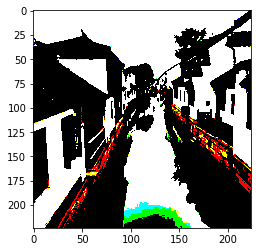

In [5]:
plt.imshow(content)

## 加载VGG-19模型

In [3]:
def vgg_params(): 
    #global _vgg_params 
    #if _vgg_params is None: 
    _vgg_params = sio.loadmat('/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/imagenet-vgg-verydeep-19.mat') 
    return _vgg_params
def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

## 定义内容损失函数

In [6]:
def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    #print ('content_features.get_shape() : ')
    #print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

## 定义风格损失函数

In [7]:
def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    #print ('target_features.get_shape() : ')
    #print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

## 定义损失函数

In [5]:
def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    #content_loss = content_loss(target_features=target_features,content_features=content_features)
    #style_loss = style_loss(target_features=target_features,style_features=style_features)
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss

## 定义风格转化函数

In [8]:
def stylize(style_image,content_image,learning_rate=0.1,epochs=50): 
    # 结果图片 
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32) 
    style_input = tf.constant(style_image,dtype=tf.float32) 
    content_input = tf.constant(content_image, dtype=tf.float32) 
    cost = loss_function(style_input,content_input,target) 
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess: 
        sess.run(tf.global_variables_initializer())
        for i in range(epochs): 
            _,loss,target_image = sess.run([train_op,cost,target]) 
            print("iter:%d,loss:%.9f" % (i, loss)) 
            if (i+1) % 10 == 0: 
                image = np.clip(target_image + 128,0,255).astype(np.uint8) 
                plt.imshow(image)
                Image.fromarray(image).save("/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/neural_me/%d.jpg" % (i + 1))

## 赋值

In [9]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 1
STYLE_LAYERS = ['relu1_2','relu2_2','relu3_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

## 主函数

iter:0,loss:17404.535156250
iter:1,loss:17185.437500000
iter:2,loss:16948.472656250
iter:3,loss:16703.671875000
iter:4,loss:16455.923828125
iter:5,loss:16207.684570312
iter:6,loss:15960.361328125
iter:7,loss:15714.843750000
iter:8,loss:15471.742187500
iter:9,loss:15231.462890625
iter:10,loss:14994.331054688
iter:11,loss:14760.553710938
iter:12,loss:14530.294921875
iter:13,loss:14303.681640625
iter:14,loss:14080.785156250
iter:15,loss:13861.634765625
iter:16,loss:13646.238281250
iter:17,loss:13434.609375000
iter:18,loss:13226.718750000
iter:19,loss:13022.552734375
iter:20,loss:12822.085937500
iter:21,loss:12625.294921875
iter:22,loss:12432.141601562
iter:23,loss:12242.578125000
iter:24,loss:12056.573242188
iter:25,loss:11874.072265625
iter:26,loss:11695.020507812
iter:27,loss:11519.356445312
iter:28,loss:11347.046875000
iter:29,loss:11178.038085938
iter:30,loss:11012.268554688
iter:31,loss:10849.686523438
iter:32,loss:10690.248046875
iter:33,loss:10533.889648438
iter:34,loss:10380.56054

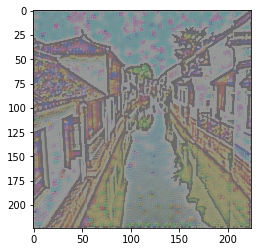

In [13]:
#if __name__ == '__main__':
    #style = Image.open('star.jpg')
    #style = np.array(style).astype(np.float32) - 128.0
    #content = Image.open('me.jpg')
    #content = np.array(content).astype(np.float32) - 128.0
stylize(style,content,0.5,50)
    
    #print(content.shape)
    #print(style.shape)